<a href="https://colab.research.google.com/github/betoval/learning-tensorflow/blob/master/titanic-estimator-roc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np

In [341]:
#we use pandas to load the csv files
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
#showing some of the data
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


We note that we have the word "NaN" in the 'Age' feature, which means that we are missing those values.

In [342]:
total = train.isnull().sum().sort_values(ascending=False)
total.head()

Cabin       687
Age         177
Embarked      2
Fare          0
Ticket        0
dtype: int64

In [343]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Here, we note that we are missing 177 values of Age, 687 of Cabin, and 2 of Embarked. As a first attemp we will replace the missing values of Age with the value of the "mean age" and the Embarked values with S, which is the most common.

In [344]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We can see that the data has 11 features + Survived (the feature we are interested in).

Below, we can examine the statistics of the data using `pd.DataFrame.describe`

In [345]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


It is evident that we are missing 177 'Age' values. We need to take care of that.

Of course, not all features are useful. In fact, we don't need the following: PassengerID, ticket, Name because they don't tell us anything about the survival rate. It is important to note that the Cabin feature could be useful, however, we will drop it because of its missing values.

In [346]:
#show train columns
train.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [347]:
#show test columns
test.columns.values

array(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [348]:
#obtain the mean age to replace the missing values
train.mean(axis=0)

PassengerId    446.000000
Survived         0.383838
Pclass           2.308642
Age             29.699118
SibSp            0.523008
Parch            0.381594
Fare            32.204208
dtype: float64

In [349]:
#features
train_x = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin','Survived'],
                     axis=1)
#label
train_y = train['Survived']
#test dataset, doesn't include the label
test_x = test.drop(['PassengerId','Name', 'Ticket', 'Cabin'],axis=1)
#train_y only includes 0 and 1 (dead or alive)
print(train_y)

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64


In [0]:
#fill the Age feature with the mean, which is 30
train_x['Age'] = train_x['Age'].fillna(30)

In [0]:
#fill Embarked with S, the most common value
train_x["Embarked"].fillna("S", inplace = True) 

In [352]:
#train_x is the "complete" train data
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


In [353]:
#indeed, the test_x dataset doesn't include Survived
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


In [354]:
test_x.mean(axis=0)

Pclass     2.265550
Age       30.272590
SibSp      0.447368
Parch      0.392344
Fare      35.627188
dtype: float64

In [0]:
test_x['Age'] = test_x['Age'].fillna(30)
test_x['Fare'] = test_x['Fare'].fillna(36)

In [356]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


In [357]:
#separate survivors
survived_label = train.groupby(['Survived'])
alive = survived_label.get_group(1)
alive

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...,...
875,876,1,3,"Najib, Miss. Adele Kiamie ""Jane""",female,15.0,0,0,2667,7.2250,NaN,C
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
880,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S


In [358]:
dead = survived_label.get_group(0)
dead

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [359]:
#ALIVE
#features
alive_x = alive.drop(['PassengerId', 'Name', 'Ticket', 'Cabin','Survived'],
                     axis=1)
#label
alive_y = alive['Survived']
alive_x['Age'] = alive_x['Age'].fillna(30)
alive_x["Embarked"].fillna("S", inplace = True) 
alive_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 1 to 889
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    342 non-null    int64  
 1   Sex       342 non-null    object 
 2   Age       342 non-null    float64
 3   SibSp     342 non-null    int64  
 4   Parch     342 non-null    int64  
 5   Fare      342 non-null    float64
 6   Embarked  342 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 21.4+ KB


In [360]:
#DEAD
#features
dead_x = dead.drop(['PassengerId', 'Name', 'Ticket', 'Cabin','Survived'],
                     axis=1)
#label
dead_y = dead['Survived']
dead_x['Age'] = dead_x['Age'].fillna(30)
dead_x["Embarked"].fillna("S", inplace = True) 
dead_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    549 non-null    int64  
 1   Sex       549 non-null    object 
 2   Age       549 non-null    float64
 3   SibSp     549 non-null    int64  
 4   Parch     549 non-null    int64  
 5   Fare      549 non-null    float64
 6   Embarked  549 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 34.3+ KB


In [0]:
#ALIVE
#sampling 80% for train data and 20% for validation
train_alive_x, val_alive_x, train_alive_y, val_alive_y = train_test_split(alive_x, alive_y, 
                                                  test_size=0.2, 
                                                  random_state=1)

#create input function
train_alive_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=train_alive_x,
                                                               y=train_alive_y,
                                                               num_epochs=None,
                                                               batch_size=100,
                                                               shuffle=True)

#validation function
val_alive_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=val_alive_x,
                                                             y=val_alive_y,
                                                              num_epochs=1,
                                                              batch_size=
                                                             len(val_alive_x),
                                                              shuffle=False)

In [0]:
#DEAD
#sampling 80% for train data and 20% for validation
train_dead_x, val_dead_x, train_dead_y, val_dead_y = train_test_split(dead_x, dead_y, 
                                                  test_size=0.2, 
                                                  random_state=1)

#create input function
train_dead_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=train_dead_x,
                                                               y=train_dead_y,
                                                               num_epochs=None,
                                                               batch_size=100,
                                                               shuffle=True)

#validation function
val_dead_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=val_dead_x,
                                                             y=val_dead_y,
                                                              num_epochs=1,
                                                              batch_size=
                                                             len(val_dead_x),
                                                              shuffle=False)

features = dataframe that includes all the necessary data to determinate if a passenger will survive or not.

labels = dataframe containing the information we want to predict. In this example, "Survived" is the label.

We need to split the train dataset into three parts:

1. Training

2. Validation

3. Test

In this example, the Test dataset is already provided. We just need to split 
the train dataset into: Train and Validation (sometimes called crossvalidation)

In [0]:
#sampling 80% for train data and 20% for validation
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, 
                                                  test_size=0.2, 
                                                  random_state=1)

#create input function
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=train_x,
                                                               y=train_y,
                                                               num_epochs=None,
                                                               batch_size=100,
                                                               shuffle=True)

#validation function
val_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=val_x,
                                                             y=val_y,
                                                              num_epochs=1,
                                                              batch_size=
                                                             len(val_x),
                                                              shuffle=False)

                                                      

**Feature Columns**

In this example, we have Categorical columns and numerical columns

In [0]:
#the layman implementation of feature columns
Sex = tf.feature_column.categorical_column_with_vocabulary_list("Sex", ["male", "female"])
Embarked = tf.feature_column.categorical_column_with_vocabulary_list("Embarked", ["S", "C", "Q"])
Age = tf.feature_column.numeric_column("Age")
Fare = tf.feature_column.numeric_column("Fare")
Parch = tf.feature_column.numeric_column("Parch")
Pclass = tf.feature_column.numeric_column("Pclass")
SibSp = tf.feature_column.numeric_column("SibSp")

ft_columns = [tf.feature_column.indicator_column(Sex), tf.feature_column.indicator_column(Embarked), Age, Fare, Parch, Pclass, SibSp]



```
feature_columns = []
num_cols = ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp']
for num_name in num_cols:
  feature_columns.append(tf.feature_column.numeric_column(num_name))

categorical_cols = ['Sex', 'Embarked']
for ft_name in categorical_cols:
  vocabulary = train_x[ft_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(ft_name, vocabulary))
```



**Instantiate the Estimator**

We are going to use a Linear Classifier. This will train the model to classify the data into two possible cases: survival and not survival.

hidden_units = number of hidden nodes per layer. Ex. [30,10] means that we have two layers, the first one with 30 nodes and the second one with 10 nodes.

n_classes= number of label classes

In [365]:
model = tf.estimator.DNNClassifier(feature_columns=ft_columns,
                                   hidden_units=[35,25,30], 
                                   n_classes=2, 
                                   optimizer='Adam')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpxpfs5len', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


**Train the model**

In [366]:
model.train(input_fn=train_input_fn, steps=500)

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpxpfs5len/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 2.3703175, step = 0
INFO

**Evaluate the model**

In [367]:
accuracy_score = model.evaluate(input_fn=val_alive_fn)["accuracy"]
print("\nTest accuracy: {0:f}%\n".format(accuracy_score*100))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-05-08T15:16:05Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpxpfs5len/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.89166s
INFO:tensorflow:Finished evaluation at 2020-05-08-15:16:06
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.76811594, accuracy

**TEST DATA**

In [0]:
test_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=test_x,
                                                              num_epochs=1,
                                                              batch_size=len(test_x),
                                                              shuffle=False)

In [369]:
LABEL =['YOU DIED', 'YOU LIVED']
lista = []
predictions = model.predict(input_fn=val_alive_fn)
for i, predict in enumerate(predictions):
    lista.append(predict['probabilities'][1])
    label_ = predict['class_ids'][0]
    probs = predict['probabilities'][label_]
    print(f'Prediction \t{LABEL[label_]} ({100*probs} %) ')

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpxpfs5len/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction 	YOU DIED (88.13487887382507 %) 
Prediction 	YOU LIVED (55.13973832130432 %) 
Prediction 	YOU LIVED (74.1417646408081 %) 
Prediction 	YOU DIED (52.22824215888977 %) 
Prediction 	YOU DIED (58.6589515209198 %) 
Prediction 	YOU LIVED

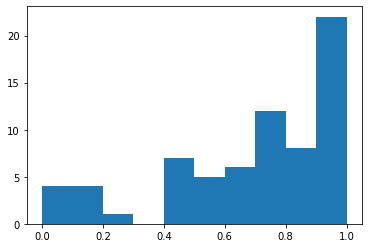

In [370]:
histograma = plt.hist(lista, range=(0,1))

In [371]:
histograma[0]
histograma[1]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32)

In [372]:
LABEL =['YOU DIED', 'YOU LIVED']
lista2 = []
predictions2 = model.predict(input_fn=val_dead_fn)
for i, predict in enumerate(predictions2):
    lista2.append(predict['probabilities'][1])
    label_ = predict['class_ids'][0]
    probs = predict['probabilities'][label_]
    print(f'Prediction \t{LABEL[label_]} ({100*probs} %) ')

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpxpfs5len/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction 	YOU DIED (88.65135908126831 %) 
Prediction 	YOU LIVED (87.59400248527527 %) 
Prediction 	YOU DIED (92.51335859298706 %) 
Prediction 	YOU DIED (93.95194053649902 %) 
Prediction 	YOU LIVED (72.6947546005249 %) 
Prediction 	YOU DIED

Text(0.5, 1.0, 'Results using a DNN')

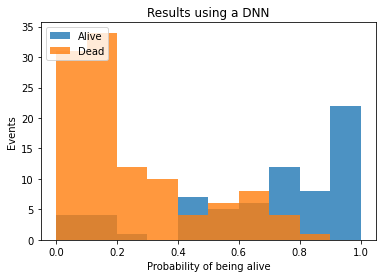

In [373]:
plt.hist(lista, range=(0,1), alpha=0.8,label='Alive')
plt.hist(lista2, range=(0,1), alpha=0.8, label='Dead')
plt.legend(loc='upper left')
plt.xlabel('Probability of being alive')
plt.ylabel('Events')
plt.title('Results using a DNN')

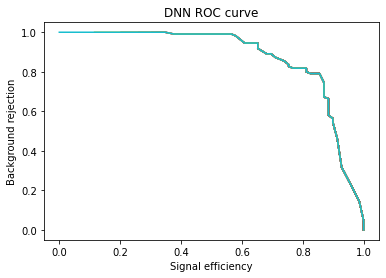

In [400]:
#CREEMOS DATOS ALEADORIOS Y ORDENEMOLOS DE MENOR A MAYOR

lista = sorted(lista)
lista2 = sorted(lista2)

#LISTAS DONDE SE GUARDARAN LOS VALORES DE EFICIENCIA Y BACK_REJECTION
eficiency = []
background_rejection = []

#ITERAMOS SOBRE UN FLOAT QUE VA DE 0 A 100 EN 1000 PASOS
for cut in np.linspace(0,1, 50):
    
    #INICIALIZAMOS EL VALOR DE VIVOS ACEPTADOS Y MUERTOS RECHAZADOS
    #PUES EN EL CORTE = 0 ACEPTAMOS TODOS LOS 1s Y RECHAZAMOS TODOS LOS 0s
    vivos_aceptados = len(lista)
    muertos_rechazados = 0


    for i, v in enumerate(lista):
        # YA QUE LAS LISTAS ESTAN ORDENADAS BASTA CON CHECAR EL PRIMER VALOR QUE 
        # SEA MAYOR QUE EL CORTE
        if cut<=v:
            vivos_aceptados-=i
            break
        #EN EL CASO DE QUE EL CORTE SEA MAYOR QUE TODAS LAS PROBS CONSIDERA QUE 
        # NINGUN VIVO FUE ACEPTADO
        if i==len(lista)-1:
            vivos_aceptados=0

    # ANALOGAMENTE PARA LOS MUERTOS        
    for i, m in enumerate(lista2):
        if cut<=m:
            muertos_rechazados+=i
            break
        if i==len(lista2)-1:
            muertos_rechazados=len(lista2)
    
    #ALMACENA EN LA LISTA
    eficiency.append(vivos_aceptados/len(lista))
    background_rejection.append(muertos_rechazados/len(lista2))

    neural = plt.plot(eficiency, background_rejection)
    plt.xlabel('Signal efficiency')
    plt.ylabel('Background rejection')
    plt.title('DNN ROC curve')

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpxpfs5len/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


(0.0, 0.05500000000000001)

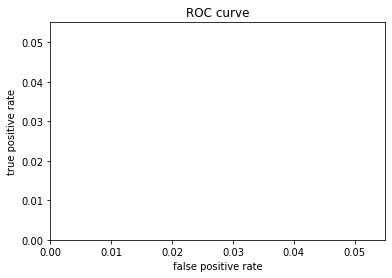

In [394]:
pred_dicts = list(model.predict(input_fn=val_alive_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

fpr, tpr, _ = roc_curve(val_alive_y, probs)
plt.plot(fpr,tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)

**Boosted decision trees**

In [374]:
treemodel = tf.estimator.BoostedTreesClassifier(feature_columns=ft_columns, n_batches_per_layer=1)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_jdw8b7k', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [375]:
treemodel.train(input_fn=train_input_fn, steps=500)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp_jdw8b7k/model.ckpt.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Calling checkpoint listeners after saving checkp

In [376]:
accuracy_score = treemodel.evaluate(input_fn=val_alive_fn)["accuracy"]
print("\nTest accuracy: {0:f}%\n".format(accuracy_score*100))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-05-08T15:16:12Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp_jdw8b7k/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.52902s
INFO:tensorflow:Finished evaluation at 2020-05-08-15:16:13
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.85507244, accuracy_baseline = 1.0, auc = 0.0, auc_precision_recall = 1.0, average_loss = 0.38648587, global_step = 500, label/mean = 1.0, loss = 0.38648587, precision = 1.0, prediction/mean = 0.83862317, recall = 0.85507244
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /tmp/tmp_jdw8b7k/model.ckpt-500



In [377]:
LABEL =['YOU DIED', 'YOU LIVED']
listatree=[]
predictions = treemodel.predict(input_fn=val_alive_fn)
for i, predict in enumerate(predictions):
    listatree.append(predict['probabilities'][1])
    label_ = predict['class_ids'][0]
    probs = predict['probabilities'][label_]
    print(f'Prediction \t{LABEL[label_]} ({100*probs} %) ')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp_jdw8b7k/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction 	YOU DIED (68.96748542785645 %) 
Prediction 	YOU LIVED (64.80145454406738 %) 
Prediction 	YOU LIVED (99.98980760574341 %) 
Prediction 	YOU LIVED (98.01952242851257 %) 
Prediction 	YOU DIED (76.04814767837524 %) 
Prediction 	YOU LIVED (99.99692440032959 %) 
Prediction 	YOU LIVED (99.99903440475464 %) 
Prediction 	YOU LIVED (99.99780654907227 %) 
Prediction 	YOU LIVED (99.99709129333496 %) 
Prediction 	YOU DIED (53.744930028915405 %) 
Prediction 	YOU LIVED (71.1341142654419 %) 
Prediction 	YOU LIVED (99.99591112136841 %) 
Prediction 	YOU LIVED (99.97555613517761 %) 
Prediction 	YOU LIVED (99.99837875366211 %) 
Prediction 	YOU LIVED (98.80814552307129 %) 
Prediction 	YOU LIVED (99.08539056777954 %) 
Prediction 	YOU 

(array([ 3.,  2.,  2.,  2.,  1.,  1.,  4.,  2.,  3., 49.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

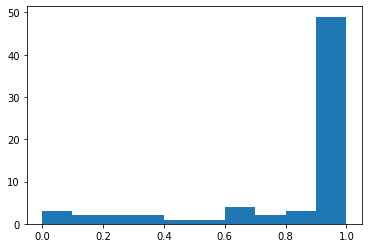

In [378]:
plt.hist(listatree, range=(0,1))

In [379]:
LABEL =['YOU DIED', 'YOU LIVED']
listatree2=[]
predictions = treemodel.predict(input_fn=val_dead_fn)
for i, predict in enumerate(predictions):
    listatree2.append(predict['probabilities'][1])
    label_ = predict['class_ids'][0]
    probs = predict['probabilities'][label_]
    print(f'Prediction \t{LABEL[label_]} ({100*probs} %) ')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp_jdw8b7k/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction 	YOU DIED (95.16227841377258 %) 
Prediction 	YOU LIVED (99.96297359466553 %) 
Prediction 	YOU DIED (99.83574748039246 %) 
Prediction 	YOU DIED (99.6888816356659 %) 
Prediction 	YOU LIVED (99.96217489242554 %) 
Prediction 	YOU DIED (99.62459206581116 %) 
Prediction 	YOU DIED (94.59988474845886 %) 
Prediction 	YOU DIED (99.0601897239685 %) 
Prediction 	YOU DIED (96.11972570419312 %) 
Prediction 	YOU DIED (95.16227841377258 %) 
Prediction 	YOU DIED (99.74573254585266 %) 
Prediction 	YOU DIED (99.98538494110107 %) 
Prediction 	YOU DIED (73.44057559967041 %) 
Prediction 	YOU DIED (74.11208748817444 %) 
Prediction 	YOU DIED (99.99313354492188 %) 
Prediction 	YOU DIED (93.09940934181213 %) 
Prediction 	YOU DIED (98.5391

(array([86.,  8.,  6.,  1.,  1.,  0.,  3.,  1.,  1.,  3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

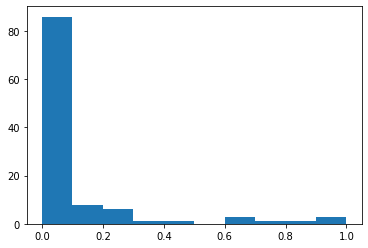

In [380]:
plt.hist(listatree2, range=(0,1))

Text(0.5, 1.0, 'Results using a BDT')

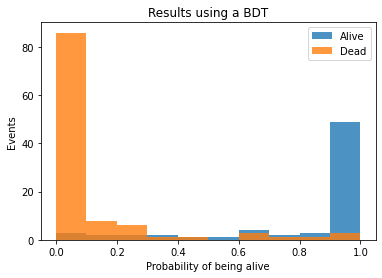

In [381]:
plt.hist(listatree, range=(0,1), alpha=0.8, label='Alive')
plt.hist(listatree2, range=(0,1), alpha=0.8, label='Dead')
plt.legend(loc='upper right')
plt.xlabel('Probability of being alive')
plt.ylabel('Events')
plt.title('Results using a BDT')

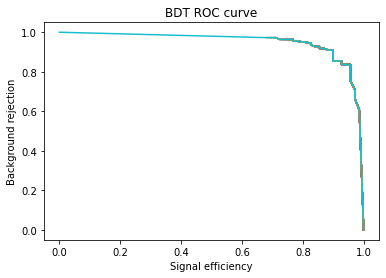

In [407]:
#CREEMOS DATOS ALEADORIOS Y ORDENEMOLOS DE MENOR A MAYOR

listatree = sorted(listatree)
listatree2 = sorted(listatree2)

#LISTAS DONDE SE GUARDARAN LOS VALORES DE EFICIENCIA Y BACK_REJECTION
eficiency2 = []
background_rejection2 = []

#ITERAMOS SOBRE UN FLOAT QUE VA DE 0 A 100 EN 1000 PASOS
for cut in np.linspace(0,1, 50):
    
    #INICIALIZAMOS EL VALOR DE VIVOS ACEPTADOS Y MUERTOS RECHAZADOS
    #PUES EN EL CORTE = 0 ACEPTAMOS TODOS LOS 1s Y RECHAZAMOS TODOS LOS 0s
    vivos_aceptados = len(listatree)
    muertos_rechazados = 0


    for i, v in enumerate(listatree):
        # YA QUE LAS LISTAS ESTAN ORDENADAS BASTA CON CHECAR EL PRIMER VALOR QUE 
        # SEA MAYOR QUE EL CORTE
        if cut<=v:
            vivos_aceptados-=i
            break
        #EN EL CASO DE QUE EL CORTE SEA MAYOR QUE TODAS LAS PROBS CONSIDERA QUE 
        # NINGUN VIVO FUE ACEPTADO
        if i==len(lista)-1:
            vivos_aceptados=0

    # ANALOGAMENTE PARA LOS MUERTOS        
    for i, m in enumerate(listatree2):
        if cut<=m:
            muertos_rechazados+=i
            break
        if i==len(lista2)-1:
            muertos_rechazados=len(listatree2)
    
    #ALMACENA EN LA LISTA
    eficiency2.append(vivos_aceptados/len(listatree))
    background_rejection2.append(muertos_rechazados/len(listatree2))

    arbol = plt.plot(eficiency2, background_rejection2)
    plt.xlabel('Signal efficiency')
    plt.ylabel('Background rejection')
    plt.title('BDT ROC curve')